In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import gpxpy
import ggps
import haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [591]:
from gps_analysis import geodesy, files, splits, garmin

In [12]:
positions = files.load_gpx("activity_768041870.gpx")
locations = pd.read_json('cam_locations.json', orient='index')
positions

,latitude,longitude,time,timeElapsed,distanceDelta,distance,bearing_r,bearing
0,52.211003,0.130434,2015-05-07 17:17:16+00:00,0 days 00:00:00,0.000000,0.000000,-2.947566,-168.883087
1,52.211131,0.130475,2015-05-07 17:18:48+00:00,0 days 00:01:32,0.014514,0.014514,-2.947566,-168.883087
2,52.211091,0.130508,2015-05-07 17:19:05+00:00,0 days 00:01:49,0.005001,0.019515,-0.475673,-27.254082
3,52.211024,0.130640,2015-05-07 17:19:12+00:00,0 days 00:01:56,0.011685,0.031200,-0.877730,-50.290213
4,52.210954,0.130768,2015-05-07 17:19:17+00:00,0 days 00:02:01,0.011636,0.042836,-0.845724,-48.456416
...,...,...,...,...,...,...,...,...
563,52.210635,0.131943,2015-05-07 18:21:05+00:00,0 days 01:03:49,0.020048,9.365145,1.865600,106.891014
564,52.210705,0.131614,2015-05-07 18:21:11+00:00,0 days 01:03:55,0.023716,9.388861,1.902649,109.013765
565,52.210758,0.131396,2015-05-07 18:21:15+00:00,0 days 01:03:59,0.016004,9.404865,1.952104,111.847345
566,52.210850,0.131081,2015-05-07 18:21:21+00:00,0 days 01:04:05,0.023780,9.428645,2.016539,115.539184


In [196]:
splits.find_all_best_times(positions).applymap(splits.strfmtsplit)

time     split
length distance                    
250m   2.683     00:57.88  01:55.76
       4.205     00:57.97  01:55.94
       2.356     00:58.75  01:57.50
       3.031     00:58.92  01:57.85
       3.678     00:59.24  01:58.49
       1.993     00:59.30  01:58.61
       4.459     00:59.44  01:58.88
       6.439     01:00.71  02:01.43
       8.166     01:01.68  02:03.36
       1.611     01:01.82  02:03.64
       7.673     01:01.96  02:03.92
       7.190     01:02.62  02:05.24
       6.706     01:03.15  02:06.31
       8.800     01:03.39  02:06.78
       9.194     01:03.90  02:07.80
       5.908     01:04.48  02:08.96
       4.987     01:04.55  02:09.10
       1.269     01:07.50  02:15.01
       8.483     01:08.21  02:16.43
       6.181     01:09.04  02:18.08
       3.361     01:09.18  02:18.37
       0.877     01:10.86  02:21.72
       5.509     01:12.56  02:25.12
       3.947     01:13.19  02:26.39
       0.615     01:13.41  02:26.83
       5.257     01:15.64  02:31.28
       0.365     01:19.82  02:39.65
       0.110     01:38.48  03:16.96
       4.712     14:50.21  29:40.43
500m   2.615     01:56.54  01:56.54
       4.163     01:57.38  01:57.38
       2.009     01:59.03  01:59.03
       6.237     02:02.63  02:02.63
       7.906     02:04.19  02:04.19
       6.986     02:08.52  02:08.52
       8.933     02:09.05  02:09.05
       1.369     02:10.10  02:10.10
       3.467     02:10.47  02:10.47
       5.002     02:20.31  02:20.31
       0.857     02:20.51  02:20.51
       8.422     02:21.19  02:21.19
       0.346     02:33.85  02:33.85
       5.650     02:35.34  02:35.34
1km    2.314     03:55.06  01:57.53
       3.699     04:09.90  02:04.95
       6.257     04:11.60  02:05.80
       7.673     04:17.74  02:08.87
       0.877     04:30.29  02:15.14
       5.157     05:03.17  02:31.58
1.5km  1.953     06:04.02  02:01.34
       5.984     06:26.97  02:08.99
       7.649     06:32.31  02:10.77
       0.365     07:03.78  02:21.26
       3.699     20:06.28  06:42.09
2km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57
3km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57
5km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57

In [194]:
splits.find_best_times(positions, 0.5).applymap(splits.strfmtsplit)

,time,split
distance,,
2.615,01:56.54,01:56.54
4.163,01:57.38,01:57.38
2.009,01:59.03,01:59.03
6.237,02:02.63,02:02.63
7.906,02:04.19,02:04.19
6.986,02:08.52,02:08.52
8.933,02:09.05,02:09.05
1.369,02:10.10,02:10.10
3.467,02:10.47,02:10.47


In [102]:
loc_timings = splits.get_location_timings(positions, locations)
loc_timings.applymap(splits.strfmtsplit)

location                 top_finish peters_post morleys_holt path_split  \
distance                      1.656       1.892        2.062      2.130   
location        distance                                                  
top_finish      1.656      00:00.00    00:31.72     01:57.89   02:05.88   
peters_post     1.892      02:14.44    00:00.00     01:26.16   01:34.15   
morleys_holt    2.062      04:50.36    08:26.83     00:00.00   00:07.99   
path_split      2.130      04:25.58    06:35.62     01:57.59   00:00.00   
fivepost        2.336      03:41.81    04:28.25     02:00.23   02:01.10   
railway         2.342      03:40.81    04:26.11     01:59.95   02:00.71   
railings        2.771      03:00.99    03:13.49     01:58.36   01:58.44   
upstream_post   2.838      02:57.22    03:07.89     01:58.02   01:58.06   
exit_ditton     3.006      02:49.74    02:57.22     01:57.87   01:57.89   
entry_ditton    3.266      02:41.41    02:46.04     01:57.93   01:57.95   
plough          3.283      02:40.93    02:45.43     01:57.89   01:57.91   
exit_grassy     3.486      02:39.14    02:42.80     02:01.73   02:01.94   
entry_grassy    3.630      02:37.12    02:40.20     02:02.62   02:02.84   
exit_firstpost  3.792      02:35.64    02:38.28     02:04.03   02:04.29   
entry_firstpost 3.966      02:33.16    02:35.30     02:03.91   02:04.14   
headstation     4.089      02:33.32    02:35.35     02:05.87   02:06.16   
outflow         4.343      02:30.54    02:32.09     02:05.65   02:05.90   
                5.225      04:20.13    04:29.03     04:16.25   04:19.29   
headstation     5.455      04:13.56    04:21.45     04:09.16   04:11.85   
entry_firstpost 5.568      04:10.09    04:17.52     04:05.43   04:07.96   
exit_firstpost  5.763      04:05.33    04:12.09     04:00.39   04:02.69   
entry_grassy    5.910      04:04.33    04:10.79     03:59.48   04:01.67   
exit_grassy     6.023      04:01.40    04:07.51     03:56.39   03:58.46   
plough          6.239      03:56.93    04:02.50     03:51.74   03:53.63   
entry_ditton    6.284      03:55.83    04:01.28     03:50.59   03:52.44   
exit_ditton     6.526      03:50.27    03:55.15     03:44.80   03:46.46   
upstream_post   6.667      03:47.16    03:51.74     03:41.59   03:43.15   
railings        6.731      03:45.86    03:50.32     03:40.25   03:41.77   
fivepost        7.168      03:38.16    03:41.90     03:32.42   03:33.69   
railway         7.187      03:37.90    03:41.62     03:32.16   03:33.44   
path_split      7.392      03:34.58    03:38.02     03:28.81   03:29.99   
morleys_holt    7.475      03:33.34    03:36.68     03:27.57   03:28.71   
peters_post     7.604      03:32.89    03:36.13     03:27.21   03:28.32   
top_finish      7.867      03:44.00    03:47.53     03:39.35   03:40.56   

location                  fivepost   railway  railings upstream_post  \
distance                     2.336     2.342     2.771         2.838   
location        distance                                               
top_finish      1.656     02:30.83  02:31.47  03:21.81      03:29.47   
peters_post     1.892     01:59.10  01:59.74  02:50.08      02:57.75   
morleys_holt    2.062     00:32.94  00:33.58  01:23.92      01:31.58   
path_split      2.130     00:24.94  00:25.59  01:15.92      01:23.59   
fivepost        2.336     00:00.00  00:00.64  00:50.97      00:58.64   
railway         2.342     01:47.25  00:00.00  00:50.33      00:58.00   
railings        2.771     01:57.19  01:57.33  00:00.00      00:07.66   
upstream_post   2.838     01:56.82  01:56.93  01:54.43      00:00.00   
exit_ditton     3.006     01:56.90  01:56.99  01:56.37      01:57.15   
entry_ditton    3.266     01:57.25  01:57.31  01:57.30      01:57.75   
plough          3.283     01:57.22  01:57.28  01:57.24      01:57.66   
exit_grassy     3.486     02:02.09  02:02.16  02:05.07      02:06.17   
entry_grassy    3.630     02:03.12  02:03.20  02:06.13      02:07.12   
exit_firstpost  3.792     02:04.74  02:04.82  02:07.96      02:08.91   


In [358]:
i, j = np.triu_indices(len(positions), 1)
i, j

time_diffs = (
    positions.timeElapsed[j].dt.total_seconds().values - 
    positions.timeElapsed[i].dt.total_seconds().values)
time_diffs
dist_diffs =(
    positions.distance[j].values - 
    positions.distance[i].values)
time_diffs
speeds = 1000 * np.nan_to_num(dist_diffs / time_diffs)

In [364]:
best_times.groupby('length').split.min()

length
1.5km   0 days 00:01:54.792346254
1km     0 days 00:01:53.472220764
250m    0 days 00:01:50.047171826
2km     0 days 00:01:54.833386274
3km     0 days 00:02:05.042755199
500m    0 days 00:01:52.086820044
5km     0 days 00:02:13.426955227
Name: split, dtype: timedelta64[ns]

In [7]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

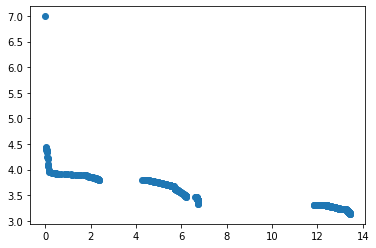

In [360]:
mask = is_pareto_efficient(np.c_[-dist_diffs, -speeds])

plt.scatter(
    dist_diffs[mask],
    speeds[mask]
)

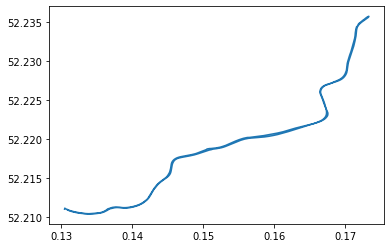

In [9]:
plt.plot(positions.longitude, positions.latitude)

In [743]:
api = garmin.login("imogen@gtsoftware.co.uk")

Input your Garmin password: ········


In [744]:
activities = garmin.get_activities(0, 1)

In [748]:
positions = garmin.load_fit_activity(activities.activityId[0])
positions

,time,position_lat,position_long,distance,enhanced_speed,speed,unknown_88,heart_rate,cadence,fractional_cadence,unknown_87,latitude,longitude,timeElapsed,distanceDelta,bearing_r,bearing
0,2022-01-03 07:56:50,614048297,-11138148,0.00000,0.000,0.000,300.0,77.0,0,0.0,NaN,51.468934,-0.933589,0 days 00:00:00,-0.00000,2.741664,157.085804
1,2022-01-03 07:56:53,614048269,-11138129,0.00000,0.000,0.000,300.0,74.0,0,0.0,NaN,51.468931,-0.933587,0 days 00:00:03,0.00022,3.019835,173.023795
2,2022-01-03 07:56:58,614048213,-11138118,0.00022,0.000,0.000,300.0,70.0,0,0.0,NaN,51.468927,-0.933586,0 days 00:00:08,0.00314,-2.456359,-140.739010
3,2022-01-03 07:57:06,614047601,-11138921,0.00336,0.000,0.000,300.0,73.0,0,0.0,NaN,51.468875,-0.933654,0 days 00:00:16,0.00043,-2.457319,-140.794002
4,2022-01-03 07:57:07,614047559,-11138976,0.00379,0.000,0.000,300.0,77.0,0,0.0,NaN,51.468872,-0.933658,0 days 00:00:17,0.00018,-2.918829,-167.236557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2022-01-03 09:25:09,614048327,-11137899,16.50760,3.356,3.356,300.0,143.0,18,0.0,1119.0,51.468936,-0.933568,0 days 01:28:19,0.00943,-2.242869,-128.506900
1081,2022-01-03 09:25:14,614047703,-11139158,16.51703,2.733,2.733,300.0,141.0,0,0.0,NaN,51.468884,-0.933673,0 days 01:28:24,0.00212,-1.889011,-108.232370
1082,2022-01-03 09:25:16,614047632,-11139504,16.51915,2.328,2.328,300.0,138.0,0,0.0,NaN,51.468878,-0.933702,0 days 01:28:26,0.00349,-1.890145,-108.297353
1083,2022-01-03 09:25:22,614047515,-11140072,16.52264,0.000,0.000,300.0,134.0,0,0.0,NaN,51.468868,-0.933750,0 days 01:28:32,0.00024,-1.980150,-113.454217


In [838]:
locations = splits.load_locations()
locations

,latitude,longitude,bearing
location,,,
start,51.461398,-0.945559,44.510065
500m,51.464605,-0.940499,44.510065
1km,51.467811,-0.935439,44.510065
1.5km,51.471017,-0.930378,44.510065
finish,51.474203,-0.925348,44.510065
cambridge_boat_house,52.399268,0.288907,78.385686
potter_space_bridge,52.403416,0.297047,25.047646
prickwillow_bridge,52.408800,0.299958,18.861604
start_marker,52.410026,0.300602,15.780618


In [826]:
pd.concat?

In [823]:
pd.read_csv("data/ely_locations.csv").to_csv(
    "data/ely_locations.tsv", sep='\t', index=False
)

In [805]:
pd.concat([
    pd.read_csv("data/ely_locations.csv", index_col=0),
    pd.read_csv("data/cam_locations.csv", index_col=0),
    locations
])

,latitude,longitude,bearing
cambridge_boat_house,52.399268,0.288907,78.385686
potter_space_bridge,52.403416,0.297047,25.047646
prickwillow_bridge,52.408800,0.299958,18.861604
start_marker,52.410026,0.300602,15.780618
500m_marker,52.414332,0.302728,30.275933
1km_marker,52.418637,0.304855,17.282350
1.5km_marker,52.422943,0.306982,15.388687
2km_marker,52.427248,0.309110,14.511991
littleport_bridge,52.453309,0.318625,5.515136
A10_bridge,52.465036,0.321689,33.259785


In [754]:
cav_locations = {
    'start': [51.461398172524824, -0.9455592979289794],
    'finish': [51.47420259934778, -0.9253479107461384],
}

In [812]:
locations = {
    'start': [51.461398172524824, -0.9455592979289794],
    '500m': [51.46460471321316, -0.9404994529495201],
    '1km': [51.467811036115336, -0.9354388968526993],
    '1.5km': [51.47101714117572, -0.930377629505215], 
    'finish': [51.47420259934778, -0.9253479107461384],
}
locations = pd.DataFrame.from_dict({
    k: {
        'latitude': v[0], 
        'longitude': v[1],
        'bearing': geodesy.estimate_bearing(
            positions, geodesy.LatLon(*v), 0.05)
    } 
    for k, v in locations.items()
},
    orient='index')
locations.index.name='location'
locations.bearing = geodesy.bearing(
    locations.loc['start'],
    locations.loc['finish']
)

In [813]:
locations.to_csv("data/cav_locations.tsv", sep='\t')

In [854]:
timings = splits.get_location_timings(positions)
timings.applymap(splits.strfsplit).to_excel("timings.xlsx")

In [842]:
splits.find_all_crossing_times(positions)

leg  location  distance
0    1km       0.185      2022-01-03 08:01:01.408169736
     500m      0.686      2022-01-03 08:04:47.466594290
     start     1.190      2022-01-03 08:08:33.135517058
1    start     1.229      2022-01-03 08:09:08.318773444
     500m      1.738      2022-01-03 08:12:02.895060362
     1km       2.243      2022-01-03 08:14:38.865722613
     1.5km     2.746      2022-01-03 08:16:57.849156436
     finish    3.237      2022-01-03 08:19:10.431539009
2    finish    3.295      2022-01-03 08:19:51.742715437
     1.5km     3.788      2022-01-03 08:22:11.430665173
     1km       4.290      2022-01-03 08:24:32.496447203
     500m      4.792      2022-01-03 08:26:54.585630517
     start     5.288      2022-01-03 08:29:13.481305941
3    start     5.358      2022-01-03 08:30:02.192405999
     500m      5.859      2022-01-03 08:32:13.122488065
     1km       6.365      2022-01-03 08:34:36.406305113
     1.5km     6.867      2022-01-03 08:36:57.415285381
     finish    7.364    

In [796]:
locations.bearing = geodesy.bearing(
    locations.loc['start'],
    locations.loc['finish']
)

In [798]:
geodesy.haversine_km(locations, locations.shift())

start          NaN
500m      0.500000
1km       0.500000
1.5km     0.500000
finish    0.496814
dtype: float64

In [791]:
geodesy.haversine_km(
    locations,
    start 
)

start     0.003234
finish    2.000000
dtype: float64

In [790]:
start = geodesy.follow_bearing(
    locations.loc['finish'],
    -2.
).to_latlon()
tuple(start)

(51.46137425904616, -0.9455858580911348)

In [794]:
pos = geodesy.follow_bearing(
    locations.loc['start'],
    1.5
).to_latlon()
tuple(pos)

(51.47101714117572, -0.930377629505215)

In [759]:
geodesy.bearing(
    locations.loc['start'],
    locations.loc['finish'])

44.51006503244349

In [ ]:
cav_locations = {
    'start': [51.46108381769548, -0.9450516671209354],
    'finish':
}

<IPython.core.display.Javascript object>


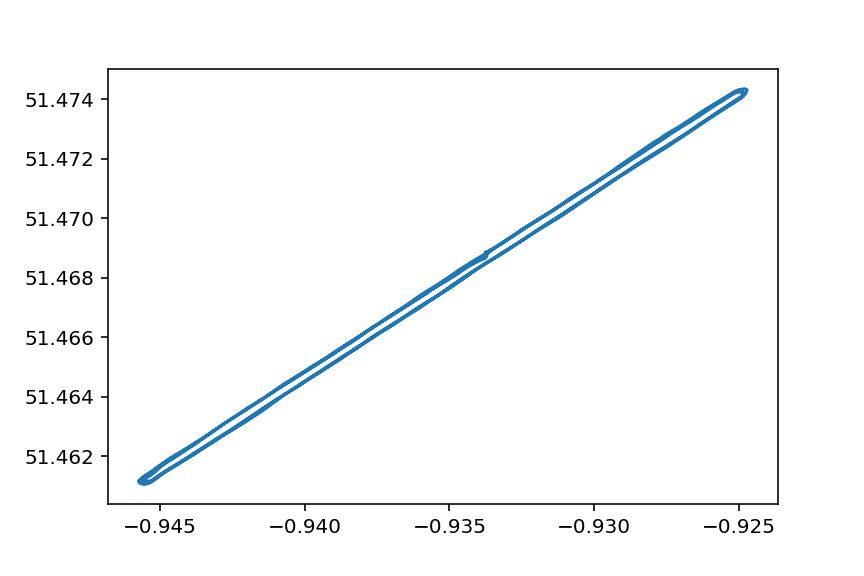

In [753]:
plt.figure()
plt.plot(positions.longitude, positions.latitude)

plt.show()

In [368]:
actid = 8026393665

positions = garmin.load_activity(actid, api=api)

In [682]:
data = garmin.load_fit_activity(actid)

please input your Garmin email address: 
imogen@gtsoftware.co.uk
Input your Garmin password: ········


In [697]:
data.time.diff(-1)

0      -1 days +23:59:57
1      -1 days +23:59:55
2      -1 days +23:59:56
3      -1 days +23:59:57
4      -1 days +23:59:59
              ...       
1464   -1 days +23:59:56
1465   -1 days +23:59:58
1466   -1 days +23:59:57
1467   -1 days +23:59:59
1468                 NaT
Name: time, Length: 1469, dtype: timedelta64[ns]

In [683]:
best_splits = splits.find_all_best_times(data)

In [688]:
best_splits.loc["2km"]

,time,split
distance,,
12.041,0 days 00:07:38.991154562,0 days 00:01:54.747788640
7.813,0 days 00:07:52.017879418,0 days 00:01:58.004469854
3.413,0 days 00:08:01.214199759,0 days 00:02:00.303549939
0.464,0 days 00:09:26.757653061,0 days 00:02:21.689413265
5.721,0 days 00:12:29.882874016,0 days 00:03:07.470718504
15.778,0 days 00:12:33.279583875,0 days 00:03:08.319895968
9.961,0 days 00:13:02.964426877,0 days 00:03:15.741106719


In [735]:
def interval_average_value(locations, label, start_dist, dist):
    interval = [start_dist, start_dist + dist]
    i0, i1 = locations.distance.searchsorted(interval)
    val = locations.loc[i0:i1, label]
    times = locations.timeElapsed.dt.total_seconds().copy()
    times.loc[[i0, i1 + 1]] = np.interp(interval, locations.distance, times)
    weights = -times.loc[i0:i1+1].diff(-1)[:-1]
    return np.average(val, weights=weights)

interval_average_value(data, 'cadence', 12.041, 2)

29.14355181605937

In [739]:
interval_average_value(data, 'cadence', 3.4, 2)

23.988371204362426

In [678]:
data.distance.diff(-1)

0      -0.00048
1      -0.00020
2      -0.00030
3      -0.00014
4      -0.00001
         ...   
1464   -0.00488
1465   -0.00190
1466   -0.00201
1467   -0.00031
1468        NaN
Name: distance, Length: 1469, dtype: float64

<IPython.core.display.Javascript object>


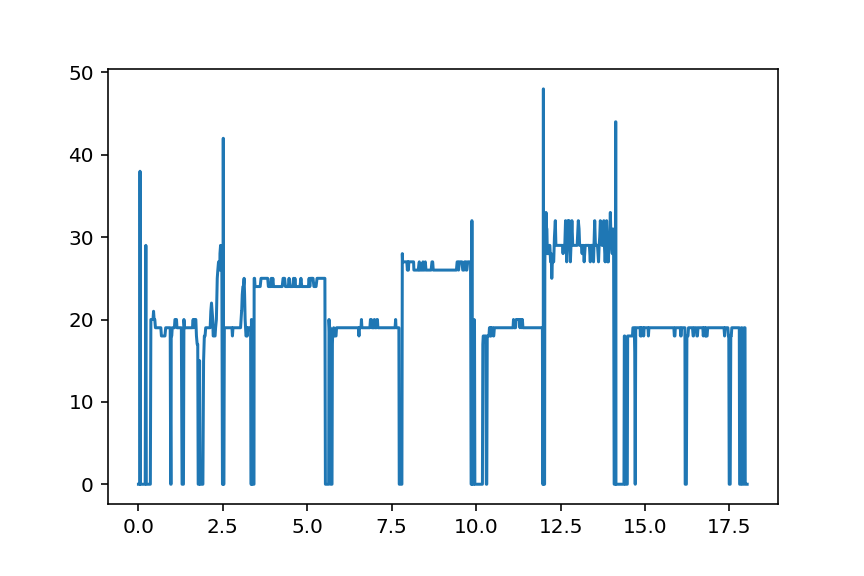

In [674]:
plt.figure()
plt.plot(data.distance, data.cadence)

<IPython.core.display.Javascript object>


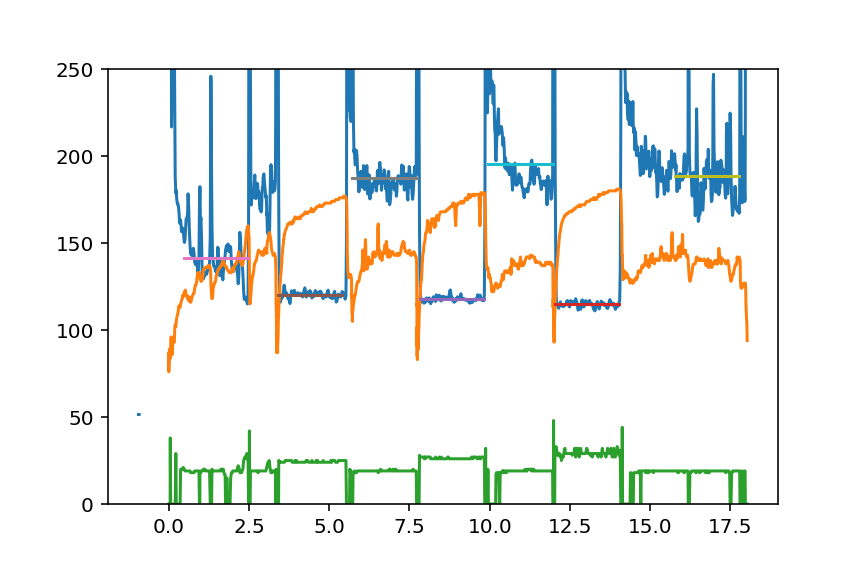

(0.0, 250.0)

In [675]:
distance = 2
dist_splits = best_splits.loc['2km']

plt.figure()
plt.plot(data.distance, 500/data.speed)
plt.plot(data.distance, data.heart_rate)
plt.plot(data.distance, data.cadence)

for d, s in dist_splits.split.iteritems():
    ts = s.total_seconds()
    plt.plot([d, d+distance], [ts, ts])
    
plt.ylim(0, 250)

In [357]:
activities = garmin.get_activities(activityType='rowing', api=api)
activity_data, errors = garmin.load_activities(activities.activityId, api=api)
garmin.activity_data_to_excel(activities, activity_data, api=api)

  0%|          | 0/20 [00:00<?, ?it/s]

In [347]:
activities = garmin.get_activities(activityType='rowing', api=api)
activity_data, errors = garmin.load_activities(activities.activityId, api=api)

  0%|          | 0/20 [00:00<?, ?it/s]